# Introduction to Synthetic Aperture Radar Using Python and MATLAB

## by Andy Harrison - &copy; Artech House 2022

---

## Example 5.6.1 Map Drift Autofocus
---

**Import modules**

In [1]:
%matplotlib inline

import numpy as np

from matplotlib import pyplot as plt

from scipy.constants import pi

import h5py

import sys

**Load the data**

In [2]:
f = h5py.File('ICEYE_SLC.h5', 'r')

**Form complex image data**

In [3]:
s = f['s_i'][:] + 1j * f['s_q'][:]

s = s.T

**Set the dynamic range for the image (dB)**

In [4]:
dynamic_range = 60

**Get the data size and calculate the image ratio**

In [5]:
nx, ny = s.shape

ratio = ny/nx

**Set the offset from image center**

In [6]:
offset_x = 0
offset_y = 0

xc = np.round(nx/2) - offset_x
yc = np.round(ny/2) - offset_y

# OR - specify a span / or fixed aspect

xs = 1000
ys = 2000
# ys = np.round(ratio * xs)

# OR - Use the full image
# xs = nx/2-1
# ys = ny/2-1

index_x = [xc - xs, xc + xs]
index_y = [yc - ys, yc + ys]

# OR - Specific region
# index_x = [1, 19310]
# index_y = [1, 5000]

xs = np.round( (index_x[1] - index_x[0]) / 2)
ys = np.round( (index_y[1] - index_y[0]) / 2)

#**Extract desired image area**
s = s[int(index_x[0]-1):int(index_x[1]), int(index_y[0]-1):int(index_y[1])]

nx, ny = s.shape

**Calculate the phase error**

In [7]:
t = np.linspace(-10.0, 10.0, int(nx))

phi = t**2

**Calculate the phase error term**

In [8]:
phase_term = np.outer(np.exp(1j * phi.T), np.ones(ny))

sf = np.fft.fftshift(np.fft.fft(s, axis=0), 0)

s_e = np.fft.ifft(phase_term * sf, axis=0)

**Make the two subaperture images**

In [9]:
t1 = np.linspace(-10, 0, int(nx))
t2 = np.linspace(0, 10, int(nx))

phi1 = t1**2
phi2 = t2**2

phase_term1 = np.outer(np.exp(1j * phi1), np.ones(ny))
phase_term2 = np.outer(np.exp(1j * phi2), np.ones(ny))

image1 = np.fft.ifft(phase_term1 * sf)
image2 = np.fft.ifft(phase_term2 * sf)

**Calculate the moving average**

In [10]:
# Calculate the moving averages for the images
image1 = np.apply_along_axis(lambda m: np.convolve(m, np.ones(32), mode='same'), axis=1, arr=image1) / 32
image2 = np.apply_along_axis(lambda m: np.convolve(m, np.ones(32), mode='same'), axis=1, arr=image2) / 32

**Calculate the cross-power spectrum of the original and transformed images**

In [11]:
image_original_spectrum = np.fft.fft(image1, axis=1)
image_transformed_spectrum = np.fft.fft(image2, axis=1)

translation = abs(np.fft.ifft(image_original_spectrum * np.conj(image_transformed_spectrum) / (abs(image_original_spectrum) * abs(image_transformed_spectrum)), axis=0))

**Find the peak error location**

In [12]:
column = translation[:,int(ny/2)].argmax()

phase_error_peak = column * pi

**Calculate the phase correction**

In [13]:
tc = np.linspace(-1, 1, int(nx))

phi_correction = phase_error_peak * tc**2

**Calculate the phase correction term**

In [14]:
phase_term = np.outer(np.exp(-1j * phi_correction), np.ones(int(ny)))

**Calculate the corrected image**

In [15]:
sef = np.fft.fft(s_e, axis=0)
                 
s_c = np.fft.ifft(phase_term * sef, axis=0)

**Display the original image**

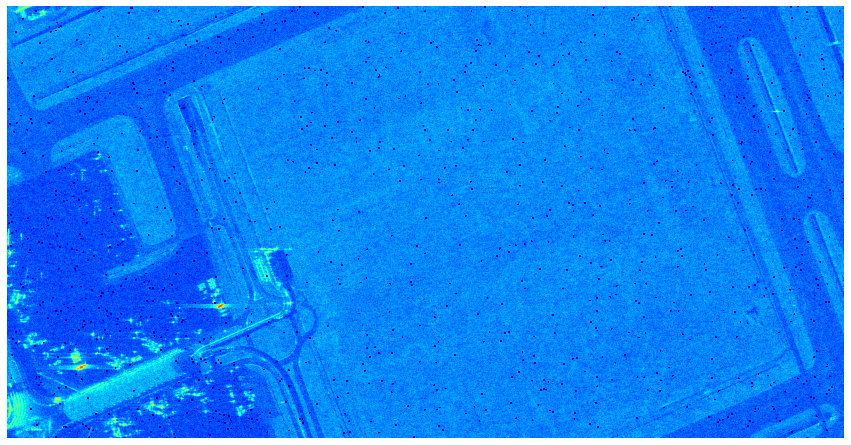

In [16]:
# Set the figure size

plt.rcParams["figure.figsize"] = (15, 12)



# Plot the original image

plt.figure

plt.imshow(20 * np.log10(np.abs(s.T) / np.max(np.abs(s)) + sys.float_info.min), cmap='jet', vmin=-abs(dynamic_range), vmax=0)



# Turn off the axis ticks

plt.axis('off')



# Make the axes match the image ratio

plt.gca().set_aspect(aspect=1/ratio, adjustable='box')



# Show the figure

plt.show()

**Display the corrupted image**

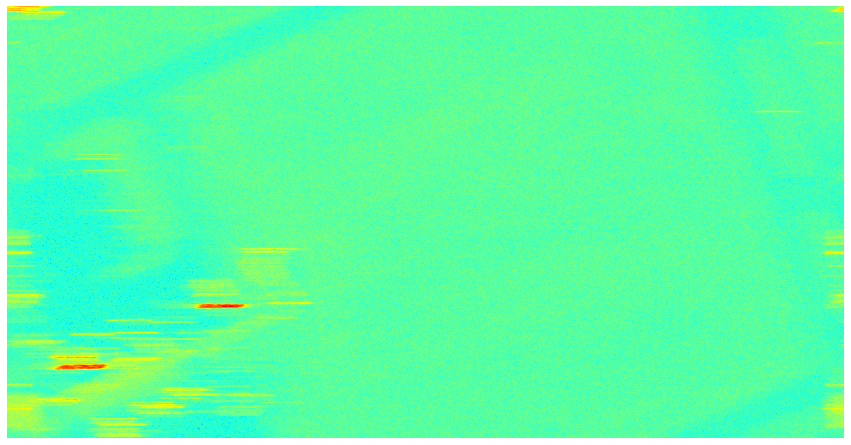

In [17]:
# Plot the corrupted image

plt.figure

plt.imshow(20 * np.log10(np.abs(s_e.T) / np.max(np.abs(s_e)) + sys.float_info.min), cmap='jet', vmin=-abs(dynamic_range), vmax=0)



# Turn off the axis ticks

plt.axis('off')



# Make the axes match the image ratio

plt.gca().set_aspect(aspect=1/ratio, adjustable='box')



# Show the figure

plt.show()

**Compare phase error**

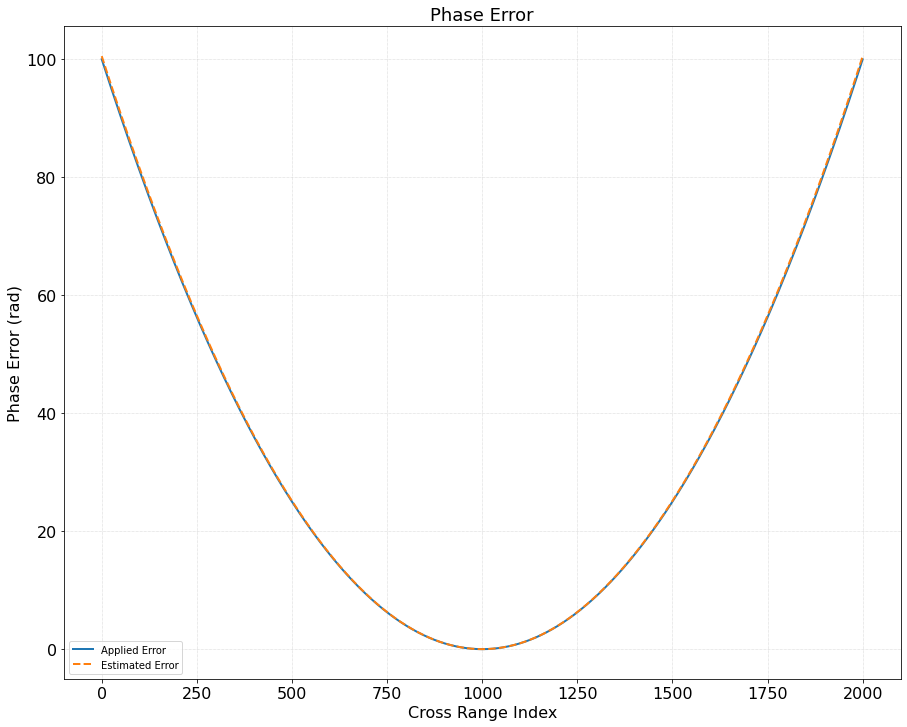

In [18]:
# Plot the phase error

plt.figure

plt.plot(phi, linewidth=2, label='Applied Error')

plt.plot(phi_correction, linewidth=2, linestyle='--', label='Estimated Error')



# Set the plot title and labels

plt.title('Phase Error', size=18)

plt.xlabel('Cross Range Index', size=16)

plt.ylabel('Phase Error (rad)', size=16)



# Set the tick label size

plt.tick_params(labelsize=16)



# Turn on the grid

plt.grid(linestyle=':', linewidth=0.5)



# Display the legend

plt.legend(loc='best')



# Display the figure

plt.show()

**Display the corrected image**

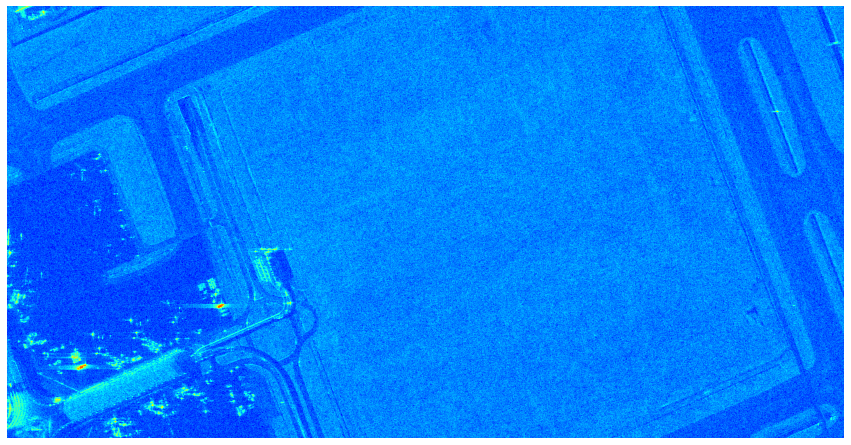

In [19]:
# Plot the corrected image

plt.figure

plt.imshow(20 * np.log10(np.abs(s_c.T) / np.max(np.abs(s_c)) + sys.float_info.min), cmap='jet', vmin=-abs(dynamic_range), vmax=0)



# Turn off the axis ticks

plt.axis('off')



# Make the axes match the image ratio

plt.gca().set_aspect(aspect=1/ratio, adjustable='box')



# Show the figure

plt.show()